## Übung zu Kapitel 7

In dieser Übung geht es um die praktische Erfahrung mit den Klassifikationsalgorithmen. Hierzu wenden wir die Algorithmen auf einen Datensatz an, vergleichen die Güte und versuchen, gute Parameter zu finden. Letzteres, also die Wahl der Parameter, ist das Wichtigste an dieser Übung: Wie tief sollten Entscheidungsbäume sein, welche Aktivierungsfunktion ist beim MLP gut, wie viele Nachbarn braucht der $k$-Nearest Neighbor und welche Kernfunktion liefert bei der SVM gute Ergebnisse?

Für diese Übung benutzen wir [Daten über die Arten von Bäumen in einem Wald aus scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype). 

### Trainings- und Testdaten

Laden Sie die Daten. Teilen Sie die Daten so auf, dass Sie 5% der Daten zum Training verwenden und 95% der Daten zum Testen ([Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)). Auch wenn man in der Praxis mehr Daten zum Training nutzen würde, ist die kleinere Trainingsmenge für diese Übung aufgrund der Laufzeit sinnvoller. Verwenden Sie *Stratified Sampling*, um sicherzustellen, dass alle Klassen entsprechend ihrer Verteilung in den Trainings- und Testdaten repräsentiert sind.

Zuerst laden wir die Daten und importieren die benötigten Algorithmen. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_covtype
from sklearn.metrics import precision_recall_fscore_support,matthews_corrcoef
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

forests = fetch_covtype()
X = forests.data
Y = forests.target

print(forests.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional a

Anschließend werfen wir einen Blick auf die Verteilung der Klassen. Man sieht, dass nicht alle Klassen gleich stark vertreten sind. 

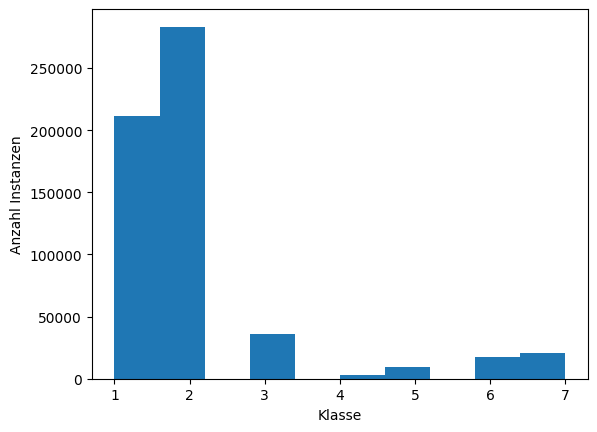

In [2]:
plt.figure()
plt.hist(Y)
plt.ylabel('Anzahl Instanzen')
plt.xlabel('Klasse')
plt.show()

Nun trennen wir die Daten in Trainings- und Testdaten.

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.95, random_state=42, stratify=Y)

Um Sicherzustellen, dass das Stratified Sampling wie gewünscht funktioniert hat, überprüfen wir die Verteilung der Klassen in den Trainingsdaten.

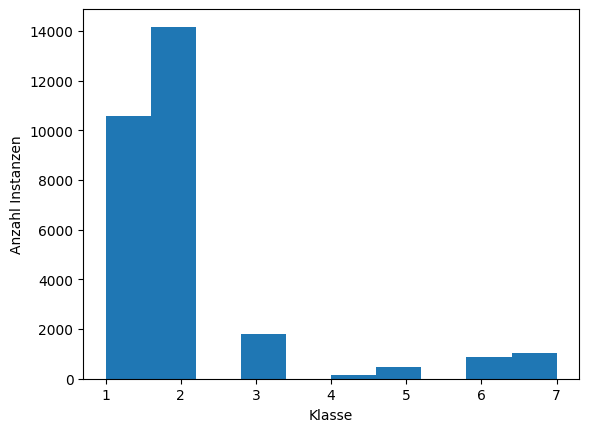

In [4]:
plt.figure()
plt.hist(Y_train)
plt.ylabel('Anzahl Instanzen')
plt.xlabel('Klasse')
plt.show()

### Trainieren, Testen, Bewerten

Nutzen Sie die Trainingsdaten, um die Algorithmen aus diesem Kapitel auszuprobieren. Hierbei werden Sie erhebliche Laufzeitunterschiede feststellen. Einige Algorithmen sind möglicherweise gar nicht für diese Daten geeignet.

Finden Sie einen guten Algorithmus für die Daten. Dieser sollte zwei Bedingungen erfüllen:

- Das Training und die Vorhersagen sollten in einer akzeptablen Zeit durchführbar sein. Nutzen Sie "weniger als 10 Minuten" als Definition von "akzeptabel" für diese Übung.
- Die Güte, gemessen mit MCC, Recall, Precision und F1-Score, sollte gut sein.

Probieren Sie verschiedene Parameter aus, um die Ergebnisse zu verbessern.



Wir trainieren $k$-Nearest-Neighbor-Modelle mit $k=3, 5, 10$, Entscheidungsbäume mit einer maximalen Tiefe von 5, 10, und 20, Random Forests mit 1000 Bäumen und einer Tiefe von 3 und 5, eine logistische Regression, ein Gaussian Naive Bayes Model, sowie MLPs mit drei Hidden Layern, 100 Neuronen je Layer und RelU und tanh als Aktivierungsfunktion. Wir testen also verschieden Parameter, die die Modellkomplexität beeinflussen. Wir trainieren keine SVM, da das Training länger als 10 Minuten dauert. 

In [5]:
classifiers = [KNeighborsClassifier(3),
               KNeighborsClassifier(5),
               KNeighborsClassifier(10),
               DecisionTreeClassifier(max_depth=5),
               DecisionTreeClassifier(max_depth=10),
               DecisionTreeClassifier(max_depth=20),
               RandomForestClassifier(n_estimators=1000, max_depth=3),
               RandomForestClassifier(n_estimators=1000, max_depth=5),
               LogisticRegression(max_iter=100000),
               GaussianNB(),
               MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                             max_iter=10000, activation='relu'),
               MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                             max_iter=10000, activation='tanh')]

clf_names = ["Nearest Neighbors (k=3)",
             "Nearest Neighbors (k=5)",
             "Nearest Neighbors (k=10)",
             "Entscheidungsbaum (Maximale Tiefe=5)",
             "Entscheidungsbaum (Maximale Tiefe=10)",
             "Entscheidungsbaum (Maximale Tiefe=20)",
             "Random Forest (Maximale Tiefe=3)",
             "Random Forest (Maximale Tiefe=5)",
             "Logistische Regression",
             "Gaussian Naive Bayes",
             "MLP (RelU)",
             "MLP (tanh)"]

scores_micro = dict()
scores_macro = dict()
scores_mcc = dict()
for name, clf in zip(clf_names, classifiers):
    print("Trainiere", name)
    clf.fit(X_train, Y_train)
    print("Vorhersagen für", name)
    Y_pred = clf.predict(X_test)
    scores_micro[name] = precision_recall_fscore_support(
        Y_test, Y_pred, average="micro")
    scores_macro[name] = precision_recall_fscore_support(
        Y_test, Y_pred, average="macro")
    scores_mcc[name] = matthews_corrcoef(Y_test, Y_pred)

scores_micro_df = pd.DataFrame(scores_micro, index=[
                               'precision (micro)', 'recall (micro)', 'fscore (micro)', 'support'])
scores_micro_df = scores_micro_df[0:3]  # drop support
scores_macro_df = pd.DataFrame(scores_macro, index=[
                               'precision (macro)', 'recall (macro)', 'fscore (macro)', 'support'])
scores_macro_df = scores_macro_df[0:3]
scores_df = pd.concat([scores_macro_df, scores_micro_df, pd.DataFrame(scores_mcc, index=['MCC'])])

Trainiere Nearest Neighbors (k=3)
Vorhersagen für Nearest Neighbors (k=3)
Trainiere Nearest Neighbors (k=5)
Vorhersagen für Nearest Neighbors (k=5)
Trainiere Nearest Neighbors (k=10)
Vorhersagen für Nearest Neighbors (k=10)
Trainiere Entscheidungsbaum (Maximale Tiefe=5)
Vorhersagen für Entscheidungsbaum (Maximale Tiefe=5)
Trainiere Entscheidungsbaum (Maximale Tiefe=10)
Vorhersagen für Entscheidungsbaum (Maximale Tiefe=10)
Trainiere Entscheidungsbaum (Maximale Tiefe=20)
Vorhersagen für Entscheidungsbaum (Maximale Tiefe=20)
Trainiere Random Forest (Maximale Tiefe=3)
Vorhersagen für Random Forest (Maximale Tiefe=3)


/home/sherbold/test/data-science-crashkurs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trainiere Random Forest (Maximale Tiefe=5)
Vorhersagen für Random Forest (Maximale Tiefe=5)


/home/sherbold/test/data-science-crashkurs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trainiere Logistische Regression


/home/sherbold/test/data-science-crashkurs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Vorhersagen für Logistische Regression
Trainiere Gaussian Naive Bayes
Vorhersagen für Gaussian Naive Bayes
Trainiere MLP (RelU)
Vorhersagen für MLP (RelU)
Trainiere MLP (tanh)
Vorhersagen für MLP (tanh)


Wir bekommen folgenende Ergebnisse.

In [6]:
scores_df

,Nearest Neighbors (k=3),Nearest Neighbors (k=5),Nearest Neighbors (k=10),Entscheidungsbaum (Maximale Tiefe=5),Entscheidungsbaum (Maximale Tiefe=10),Entscheidungsbaum (Maximale Tiefe=20),Random Forest (Maximale Tiefe=3),Random Forest (Maximale Tiefe=5),Logistische Regression,Gaussian Naive Bayes,MLP (RelU),MLP (tanh)
precision (macro),0.791444,0.783249,0.771293,0.639873,0.717181,0.724316,0.276620,0.279558,0.529462,0.382979,0.704892,0.565776
recall (macro),0.717410,0.680058,0.593826,0.461665,0.605789,0.691687,0.264727,0.300445,0.449769,0.582227,0.721218,0.421987
fscore (macro),0.749953,0.722707,0.653110,0.472032,0.638944,0.706249,0.265367,0.289531,0.474749,0.348337,0.702079,0.443529
precision (micro),0.845884,0.831648,0.803546,0.704661,0.755411,0.796734,0.658736,0.679257,0.710938,0.447357,0.793229,0.683491
recall (micro),0.845884,0.831648,0.803546,0.704661,0.755411,0.796734,0.658736,0.679257,0.710938,0.447357,0.793229,0.683491
fscore (micro),0.845884,0.831648,0.803546,0.704661,0.755411,0.796734,0.658736,0.679257,0.710938,0.447357,0.793229,0.683491
MCC,0.750444,0.726272,0.678794,0.513247,0.600219,0.671829,0.414291,0.458286,0.522613,0.293639,0.676011,0.487312


Der $k$-Nearest-Neighbor-Algorithmus liefert für $k=3$ das beste Ergebnis. Der Entscheidungsbaum und der Random Forest liefern mit größerer Tiefe bessere Ergebnisse. Für das MLP sind die Ergebnisse mit RelU besser als mit tanh. Die logistische Regression und Gaussian Naive Bayes haben mit Abstand die schlechtesten Ergebnisse. Zur weiteren Optimierung betrachten wir jetzt noch kleinere Werte für $k$, sowie größere Tiefen für die Entscheidungsbäume. Durch diese zweite Runde, in der wir die Parameter basierend auf den Ergebnissen optimieren, werden unsere Testdaten zu Validierungsdaten. 

In [7]:
classifiers = [KNeighborsClassifier(1),
               KNeighborsClassifier(2),
               KNeighborsClassifier(3),
               DecisionTreeClassifier(max_depth=20),
               DecisionTreeClassifier(max_depth=40),
               DecisionTreeClassifier(max_depth=60),
               RandomForestClassifier(n_estimators=1000, max_depth=5),
               RandomForestClassifier(n_estimators=1000, max_depth=10),
               RandomForestClassifier(n_estimators=1000, max_depth=20),
               MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                             max_iter=10000, activation='relu')]

clf_names = ["Nearest Neighbors (k=1)",
             "Nearest Neighbors (k=2)",
             "Nearest Neighbors (k=3)",
             "Entscheidungsbaum (Maximale Tiefe=20)",
             "Entscheidungsbaum (Maximale Tiefe=40)",
             "Entscheidungsbaum (Maximale Tiefe=60)",
             "Random Forest (Maximale Tiefe=5)",
             "Random Forest (Maximale Tiefe=10)",
             "Random Forest (Maximale Tiefe=20)",
             "MLP (RelU)"]

scores_micro = dict()
scores_macro = dict()
scores_mcc = dict()
for name, clf in zip(clf_names, classifiers):
    print("Trainiere", name)
    clf.fit(X_train, Y_train)
    print("Vorhersagen für", name)
    Y_pred = clf.predict(X_test)
    scores_micro[name] = precision_recall_fscore_support(
        Y_test, Y_pred, average="micro")
    scores_macro[name] = precision_recall_fscore_support(
        Y_test, Y_pred, average="macro")
    scores_mcc[name] = matthews_corrcoef(Y_test, Y_pred)

scores_micro_df = pd.DataFrame(scores_micro, index=[
                               'precision (micro)', 'recall (micro)', 'fscore (micro)', 'support'])
scores_micro_df = scores_micro_df[0:3]  # drop support
scores_macro_df = pd.DataFrame(scores_macro, index=[
                               'precision (macro)', 'recall (macro)', 'fscore (macro)', 'support'])
scores_macro_df = scores_macro_df[0:3]
scores_df = pd.concat([scores_macro_df, scores_micro_df, pd.DataFrame(scores_mcc, index=['MCC'])])

Trainiere Nearest Neighbors (k=1)
Vorhersagen für Nearest Neighbors (k=1)
Trainiere Nearest Neighbors (k=2)
Vorhersagen für Nearest Neighbors (k=2)
Trainiere Nearest Neighbors (k=3)
Vorhersagen für Nearest Neighbors (k=3)
Trainiere Entscheidungsbaum (Maximale Tiefe=20)
Vorhersagen für Entscheidungsbaum (Maximale Tiefe=20)
Trainiere Entscheidungsbaum (Maximale Tiefe=40)
Vorhersagen für Entscheidungsbaum (Maximale Tiefe=40)
Trainiere Entscheidungsbaum (Maximale Tiefe=60)
Vorhersagen für Entscheidungsbaum (Maximale Tiefe=60)
Trainiere Random Forest (Maximale Tiefe=5)
Vorhersagen für Random Forest (Maximale Tiefe=5)


/home/sherbold/test/data-science-crashkurs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trainiere Random Forest (Maximale Tiefe=10)
Vorhersagen für Random Forest (Maximale Tiefe=10)
Trainiere Random Forest (Maximale Tiefe=20)
Vorhersagen für Random Forest (Maximale Tiefe=20)
Trainiere MLP (RelU)
Vorhersagen für MLP (RelU)


Jetzt können wir betrachten ob es hierdurch weitere Verbesserungen gab. 

In [8]:
scores_df

,Nearest Neighbors (k=1),Nearest Neighbors (k=2),Nearest Neighbors (k=3),Entscheidungsbaum (Maximale Tiefe=20),Entscheidungsbaum (Maximale Tiefe=40),Entscheidungsbaum (Maximale Tiefe=60),Random Forest (Maximale Tiefe=5),Random Forest (Maximale Tiefe=10),Random Forest (Maximale Tiefe=20),MLP (RelU)
precision (macro),0.794652,0.820930,0.791444,0.723965,0.714521,0.713832,0.280821,0.837093,0.858380,0.752156
recall (macro),0.786020,0.675314,0.717410,0.693153,0.710940,0.713355,0.302368,0.476115,0.676403,0.734674
fscore (macro),0.790193,0.729274,0.749953,0.707224,0.712712,0.713554,0.291125,0.518010,0.729538,0.738763
precision (micro),0.869547,0.838348,0.845884,0.797068,0.798281,0.799738,0.683420,0.745999,0.836087,0.824992
recall (micro),0.869547,0.838348,0.845884,0.797068,0.798281,0.799738,0.683420,0.745999,0.836087,0.824992
fscore (micro),0.869547,0.838348,0.845884,0.797068,0.798281,0.799738,0.683420,0.745999,0.836087,0.824992
MCC,0.790433,0.743195,0.750444,0.672464,0.676040,0.678382,0.465183,0.579039,0.732680,0.717525


Der $1$-Nearest-Neighbor-Algorithmus liefert das insgesamt beste Ergebnis für MCC, F-Score (micro und macro), Recall (micro und macro) und Precision (micro). Lediglich bei der Precision (macro) ist das Ergebnis leicht schlechter als beim $2$-Nearest-Neighbor-Model und dem Random Forest mit einer maximalen Tiefe von 10. Man sieht weiterhin, das sich der Entscheidungsbaum mit einer Tiefe größer als 20 nicht weiter verbessert. Insgesamt liefert der Random Forest die zweitbesten Ergebnisse. 

Wie vergleichen jetzt die Confusion Matrix vom $1$-Nearest Neighbor mit dem Random Forest. 

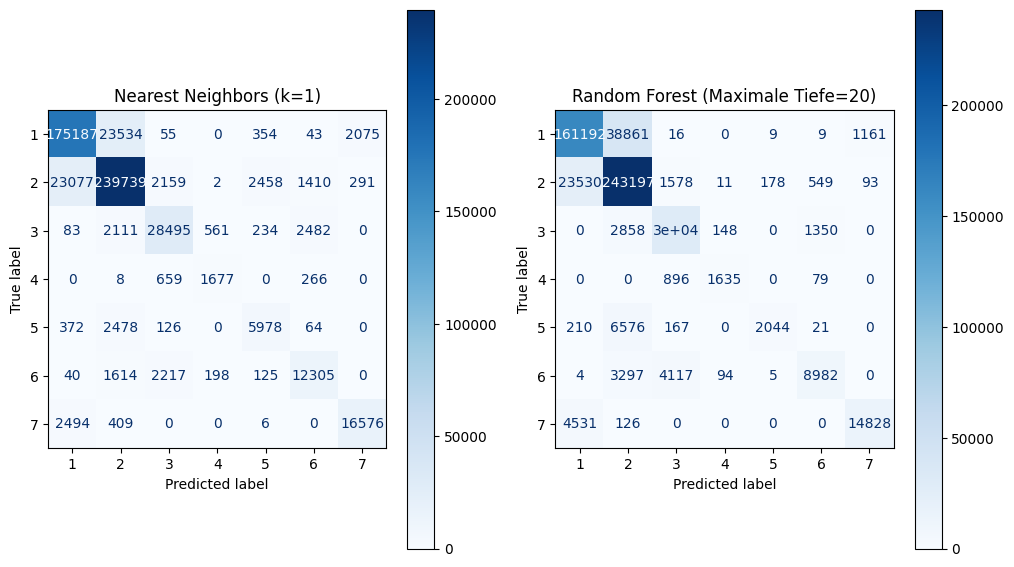

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1,2, figsize=(12,7))

ConfusionMatrixDisplay.from_estimator(estimator=classifiers[0],
                                      X=X_test, y=Y_test,
                                      cmap=plt.cm.Blues, ax=axes[0])
ConfusionMatrixDisplay.from_estimator(estimator=classifiers[8],
                                      X=X_test, y=Y_test,
                                      cmap=plt.cm.Blues, ax=axes[1])
axes[0].set_title(clf_names[0])
axes[1].set_title(clf_names[8])
plt.show()

Durch diese Auswertung erkennt man, dass der Unterschied der Modelle auf den Vorhersagen der Klassen 5 und 6 basiert. Bei beiden Klassen ist der $1$-Nearest-Neighbor-Algorithmus deutlich besser als der Random Forest. Für die anderen Klassen ist die Güte vergleichbar. 

### Automatische Parameterwahl

Sie können gute Parameter auch automatisch bestimmen. Nutzen Sie hierfür die [*Grid Search*](https://scikit-learn.org/stable/modules/grid_search.html), bei der alle Paare von Parametern aus einem vorgegebenen Wertebereich kombiniert werden. Beachten Sie, dass der Aufwand hierbei exponentiell mit der Anzahl der Parameter wächst. Probieren Sie die Grid Search aus, um noch bessere Parameter zu finden, ohne dabei länger als eine Stunde Rechenzeit zu investieren.

Bei der Parametersuche gibt es extrem viele Möglichkeiten. Hier ein Beispiel zur Optimierung eines Entscheidungsbaums. 

In [ ]:
from sklearn.model_selection import GridSearchCV

# define a parameter grid
param_grid = [
  {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40],
  'min_samples_split': [2, 10, 100, 1000], 'min_samples_leaf': [2, 10, 100, 1000]},
 ]

# tune the classifier
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring="f1_macro")
clf.fit(X_train, Y_train)

print("Beste Parameterkombination:")
print()
print(clf.best_params_)

print("Güte auf Testdaten:")

Y_true, Y_pred = Y_test, clf.predict(X_test)
print('MCC:', matthews_corrcoef(Y_test, Y_pred))
print('Micro:', precision_recall_fscore_support(Y_test, Y_pred, average="micro"))
print('Macro:', precision_recall_fscore_support(Y_test, Y_pred, average="macro"))